In [15]:
import torch
import json
from transformers import CLIPTokenizer,CLIPTextModel

In [ ]:
from torch.utils.data import Dataset
from torchvision.transforms import transforms
from PIL import Image

transform = transforms.Compose([
                                transforms.Resize((256,256)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                                ])

class CocoWithAnnotations(Dataset):
    def __init__(self,path,tokenizer,transform,train=True):
        super().__init__()
        self.path = path
        self.data = None
        self.transform = transform
        self.tokenizer = tokenizer
        self.train = train
        if self.data is None:
            self.open_json()
    
    def open_json(self):
        if self.train:
            print('======================= Loading training annotations =======================')
            with open(f'{self.path}/annotations/captions_train2014.json','r+') as stream:
                self.data = json.load(stream)
            self.data = self.data['annotations']
        else:
            print('======================= Loading validation annotations =======================')
            with open(f'./{self.path}/annotations/captions_val2014.json','r+') as stream:
                self.data = json.load(stream)
            self.data = self.data['annotations']
        print('======================= ANNOTATIONS LOADED =======================')
        
    def __getitem__(self, index):
        
        annot = self.data[index]
        if(len(str(annot['image_id']))<6):
            rem_0l = 6-len(str(annot['image_id']))
            rem_0 = ''
            for i in range(rem_0l):
                rem_0+='0'
            image = self.transform(Image.open(f'{self.path}/train2014/COCO_train2014_000000{rem_0+str(annot['image_id'])}.jpg'))
            text_emb = self.tokenizer(annot['caption'])
            return image,text_emb
        else:
            image = self.transform(Image.open(f'{self.path}/train2014/COCO_train2014_000000{annot['image_id']}.jpg'))
            text_emb = self.tokenizer(annot['caption'])
            return image,text_emb

In [11]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

# Define alpha values (cumulative product of 1 - beta)
def compute_alpha_cumprod(beta_schedule):
    alpha = 1.0 - beta_schedule
    alpha_cumprod = torch.cumprod(alpha, dim=0)
    return alpha_cumprod

# Define timesteps and compute schedule
timesteps = 1000
beta_schedule = linear_beta_schedule(timesteps)
alpha_cumprod = compute_alpha_cumprod(beta_schedule)

In [18]:


tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')

dataset = CocoWithAnnotations('./coco',tokenizer,transform)
clip_text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

# Example text
captions = ["a black and white cat in a basket on a sofa", "a sunny beach with a palm tree"]

# Tokenize text (output has input IDs and attention masks)
tokenized_captions = tokenizer(captions, padding="max_length", truncation=True, max_length=77, return_tensors="pt")

# Extract text embeddings
text_embeddings = clip_text_model(**tokenized_captions).last_hidden_state

======================= Loading training annotations =======================
======================= ANNOTATIONS LOADED =======================


Error while downloading from https://cdn-lfs.hf.co/openai/clip-vit-base-patch32/a63082132ba4f97a80bea76823f544493bffa8082296d62d71581a4feff1576f?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1733133512&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMzEzMzUxMn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9vcGVuYWkvY2xpcC12aXQtYmFzZS1wYXRjaDMyL2E2MzA4MjEzMmJhNGY5N2E4MGJlYTc2ODIzZjU0NDQ5M2JmZmE4MDgyMjk2ZDYyZDcxNTgxYTRmZWZmMTU3NmY%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIn1dfQ__&Signature=Rst8nBsU%7EtOIihbcfAB0-SWSqbqvZ6L735ghljWT3eWdjQSS5rmx2WMXWMXTOYqtztJp6oNaivgdYqEDi6Du7zNrJTxErLWThZnQWhYQ3CrfDEl0B2lzIsGk9PsyocPN7lTQ7qxhoS%7EcSKXZTE94HXcaD%7EqGZlIQXooFgU63Mj8m4adg7xAIzCkUtR5xW6jtSZeoeaHT7inD7WnlL21hPzqdYFSRCMnktp2EfnEnqZPycs6Th8m6aUJ4v4A5dhx6G9sQfCcH6wuBc9QFBVwrdTgI7NnbA6zM4BRy

ReadTimeout: (ReadTimeoutError("HTTPSConnectionPool(host='cdn-lfs.hf.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: e46afc39-8d09-4d23-a119-61990199e3a1)')

In [8]:
dataset[1]

(tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.8667, -0.8667, -0.8667,  ..., -0.8667, -0.8667, -0.8667],
          [-0.6941, -0.6941, -0.6941,  ..., -0.6941, -0.6941, -0.6941]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.8667, -0.8667, -0.8667,  ..., -0.8667, -0.8667, -0.8667],
          [-0.6941, -0.6941, -0.6941,  ..., -0.6941, -0.6941, -0.6941]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000,

In [9]:
def visualize(dataset_cell):
    import matplotlib.pyplot as plt
    inv_transform = transforms.Compose([
        transforms.Normalize(mean=[-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5], std=[1 / 0.5, 1 / 0.5, 1 / 0.5]),
        transforms.ToPILImage(),
    ])

    image = inv_transform(dataset_cell[0])
    tokens,attentin_masks = dataset_cell[1]['input_ids'],dataset_cell[1]['attention_mask']
    print(attentin_masks)
    text =tokenizer.decode(tokens,skip_special_tokens=True)
    plt.title(text)
    plt.imshow(image)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


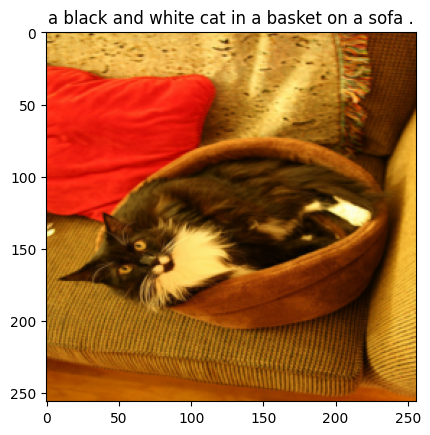

In [10]:
visualize(dataset[139192])